In [17]:
import os
import shutil
import random
from pathlib import Path

# Paths
DATASET_DIR = Path("smaller_dataset")
OUTPUT_DIR = Path("dataset_split")
TRAIN_DIR = OUTPUT_DIR / "train"
VAL_DIR   = OUTPUT_DIR / "val"
TEST_DIR  = OUTPUT_DIR / "test"

# Ratios
train_ratio = 0.7
val_ratio   = 0.15
test_ratio  = 0.15

# Make output dirs
for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Go through each class folder
for class_name in os.listdir(DATASET_DIR):
    class_path = DATASET_DIR / class_name
    if not class_path.is_dir():
        continue

    images = list(class_path.glob("*.*"))
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * train_ratio)
    n_val   = int(n_total * val_ratio)
    # test is whatever remains
    n_test  = n_total - n_train - n_val

    train_imgs = images[:n_train]
    val_imgs   = images[n_train:n_train+n_val]
    test_imgs  = images[n_train+n_val:]

    # Create subfolders
    for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
        (d / class_name).mkdir(parents=True, exist_ok=True)

    # Copy
    for img in train_imgs:
        shutil.copy(img, TRAIN_DIR / class_name / img.name)
    for img in val_imgs:
        shutil.copy(img, VAL_DIR / class_name / img.name)
    for img in test_imgs:
        shutil.copy(img, TEST_DIR / class_name / img.name)

    print(f"{class_name}: {len(train_imgs)} train, {len(val_imgs)} val, {len(test_imgs)} test")

print("✅ Split complete! New folders created at:", OUTPUT_DIR)


Braised Chicken Feet: 199 train, 42 val, 44 test
Braised Pig Trotters: 208 train, 44 val, 46 test
Braised Pork: 754 train, 161 val, 163 test
Dry Pot Cauliflower: 203 train, 43 val, 44 test
Egg Drop Soup: 198 train, 42 val, 43 test
Fish Flavored Shredded Pork: 663 train, 142 val, 143 test
Fish Head Tofu Soup: 198 train, 42 val, 43 test
Fragrant Soy-sauced Eggplant: 192 train, 41 val, 42 test
Glass Noodles with Minced Pork: 201 train, 43 val, 44 test
Hot and Sour Lotus Root Slices: 190 train, 40 val, 42 test
Kung Pao Chicken: 657 train, 140 val, 142 test
Salted Egg Yolk Pumpkin: 202 train, 43 val, 44 test
Scallion Oil Noodles: 206 train, 44 val, 45 test
Spicy Chongqing Hotpot: 209 train, 44 val, 46 test
Spicy Crab: 195 train, 41 val, 43 test
Spicy Tofu: 195 train, 41 val, 43 test
Stir-fried Pork Kidney: 195 train, 41 val, 43 test
Stir-fried Shredded Potatoes: 660 train, 141 val, 142 test
Tomato Scrambled Eggs: 711 train, 152 val, 154 test
Winter Melon Pork Rib Soup: 203 train, 43 val, 45

In [8]:
import os, json, time
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --------- CONFIG ---------
DATA_DIR = "dataset_split_2"      # your dataset root with train/val[/test]
MODEL_NAME = "efficientnet_b0"           # try resnet18 first for speed; swap to efficientnet_b0 later
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
LR = 3e-4                         # head-only phase
UNFREEZE_AT = 2                   # start fine-tuning early
NUM_WORKERS = max(2, os.cpu_count()//2)
OUT_DIR = "artifacts"
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(OUT_DIR, exist_ok=True)
print(f"Using device: {device}, workers: {NUM_WORKERS}")

Using device: cpu, workers: 6


In [9]:
import os, json
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms

# --------- Transforms ---------
def get_transforms(img_size=224):
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]
    train_tfms = transforms.Compose([
        transforms.Resize(int(img_size*1.15)),
        transforms.RandomResizedCrop(img_size, scale=(0.6, 1.0)),   # allow tighter crops
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomGrayscale(p=0.2),   # reduce color reliance
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.RandomErasing(p=0.25)     # regularization
    ])
    eval_tfms = transforms.Compose([
        transforms.Resize(int(img_size*1.15)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    return train_tfms, eval_tfms

# --------- DataLoaders with imbalance handling ---------
def build_loaders(data_dir, img_size, batch_size, workers):
    train_tfms, eval_tfms = get_transforms(img_size)
    train_ds = datasets.ImageFolder(Path(data_dir)/"train", transform=train_tfms)
    val_ds   = datasets.ImageFolder(Path(data_dir)/"val",   transform=eval_tfms)

    # Weighted sampler (to fix class imbalance)
    class_counts = np.bincount([y for _, y in train_ds.samples], minlength=len(train_ds.classes))
    class_weights = 1.0 / np.maximum(class_counts, 1)
    sample_weights = [class_weights[y] for _, y in train_ds.samples]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    train_ld = DataLoader(train_ds, batch_size=batch_size, sampler=sampler,
                          num_workers=workers, pin_memory=True,
                          persistent_workers=(workers > 0),
                          prefetch_factor=4 if workers > 0 else None)
    val_ld   = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                          num_workers=workers, pin_memory=True,
                          persistent_workers=(workers > 0),
                          prefetch_factor=4 if workers > 0 else None)
    return train_ds, val_ds, train_ld, val_ld

# --------- Usage ---------
train_ds, val_ds, train_ld, val_ld = build_loaders(DATA_DIR, IMG_SIZE, BATCH_SIZE, NUM_WORKERS)
classes = train_ds.classes
print(f"Classes ({len(classes)}): {classes}")

# Save index mapping
with open(Path(OUT_DIR)/"idx_to_class.json","w") as f:
    json.dump({i:c for c,i in train_ds.class_to_idx.items()}, f, indent=2)

Classes (10): ['Braised Chicken Feet', 'Braised Pig Trotters', 'Egg Drop Soup', 'Egg Fried Rice', 'Hot and Sour Lotus Root Slices', 'Scallion Oil Noodles', 'Spicy Chongqing Hotpot', 'Spicy Crab', 'Spicy Tofu', 'Stir-fried Shrimp with Garlic']


In [10]:
from torch.optim.lr_scheduler import CosineAnnealingLR

# ---- Model with a slightly regularized head ----
def build_model(model_name, num_classes, pretrained=True):
    name = model_name.lower()
    if name == "efficientnet_b0":
        m = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.DEFAULT if pretrained else None
        )
        in_features = m.classifier[1].in_features
        m.classifier[1] = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features, num_classes)
        )
    elif name == "resnet50":
        m = models.resnet50(
            weights=models.ResNet50_Weights.DEFAULT if pretrained else None
        )
        in_features = m.fc.in_features
        m.fc = nn.Sequential(nn.Dropout(0.2), nn.Linear(in_features, num_classes))
    else:  # resnet18
        m = models.resnet18(
            weights=models.ResNet18_Weights.DEFAULT if pretrained else None
        )
        in_features = m.fc.in_features
        m.fc = nn.Sequential(nn.Dropout(0.2), nn.Linear(in_features, num_classes))
    return m

def freeze_backbone(model, model_name):
    for p in model.parameters():
        p.requires_grad = False
    if "efficientnet" in model_name:
        for p in model.classifier.parameters():
            p.requires_grad = True
    else:
        for p in model.fc.parameters():
            p.requires_grad = True

def unfreeze_all(model):
    for p in model.parameters():
        p.requires_grad = True

# ---- Build, freeze, and set up training objects ----
model = build_model(MODEL_NAME, num_classes=len(classes)).to(device)
freeze_backbone(model, MODEL_NAME)

# Small regularization helps generalization on bigger/messier datasets
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

# Head-only phase: train classifier with a slightly higher LR
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    weight_decay=1e-4
)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

best_acc, best_path = 0.0, str(Path(OUT_DIR)/"best.pt")

# ---- In your training loop, when you unfreeze, re-init optimizer + scheduler ----
# if epoch == UNFREEZE_AT:
#     unfreeze_all(model)
#     # lower LR for fine-tuning the full backbone
#     optimizer = optim.AdamW(model.parameters(), lr=LR * 0.1, weight_decay=1e-4)
#     # reset scheduler for the remaining epochs
#     remaining = max(1, EPOCHS - epoch + 1)
#     scheduler = CosineAnnealingLR(optimizer, T_max=remaining)


C:\Users\Denzel\AppData\Local\Temp\ipykernel_24616\4185441485.py:57: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


In [11]:
%pip install torchinfo

from torchinfo import summary

# Show a summary of the model architecture
summary(model, input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE), col_names=["input_size", "output_size", "num_params", "trainable"])

Note: you may need to restart the kernel to use updated packages.


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 10]                  --                        Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─Sequential

In [12]:
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [6]:
import math
from torch.nn.utils import clip_grad_norm_

# ---- MixUp helpers (optional) ----
def mixup_data(x, y, alpha=0.2, device='cpu'):
    if alpha <= 0:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size, device=device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ---- One epoch (supports MixUp, AMP, grad clipping) ----
def train_one_epoch(model, loader, criterion, optimizer, device, scaler=None, mixup_alpha=0.0, max_grad_norm=1.0):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)

        # MixUp (only on train)
        if mixup_alpha and mixup_alpha > 0.0:
            images, targets_a, targets_b, lam = mixup_data(images, targets, alpha=mixup_alpha, device=device)
        else:
            targets_a = targets_b = targets
            lam = 1.0

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=scaler is not None):
            logits = model(images)
            if lam != 1.0:
                loss = mixup_criterion(criterion, logits, targets_a, targets_b, lam)
            else:
                loss = criterion(logits, targets)

        if scaler:
            scaler.scale(loss).backward()
            # unscale before clipping
            scaler.unscale_(optimizer)
            clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()

        running_loss += loss.item() * images.size(0)

        # For accuracy, use hard labels (argmax). With MixUp this is only an approximation.
        preds = logits.argmax(1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    return running_loss / max(1, total), correct / max(1, total)

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    all_preds, all_targets = [], []

    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        logits = model(images)
        loss = criterion(logits, targets)
        loss_sum += loss.item() * images.size(0)

        preds = logits.argmax(1)
        correct += (preds == targets).sum().item()
        total   += targets.size(0)

        all_preds.append(preds.detach().cpu().numpy())
        all_targets.append(targets.detach().cpu().numpy())

    avg_loss = loss_sum / max(1, total)
    acc = correct / max(1, total)
    y_pred = np.concatenate(all_preds) if all_preds else np.array([])
    y_true = np.concatenate(all_targets) if all_targets else np.array([])
    return avg_loss, acc, y_true, y_pred

# ---- Train loop ----
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS + 1):
    # Unfreeze at chosen epoch: lower LR and reset scheduler for remaining epochs
    if epoch == UNFREEZE_AT:
        unfreeze_all(model)
        # smaller LR for fine-tuning the whole backbone
        optimizer = optim.AdamW(model.parameters(), lr=LR * 0.1, weight_decay=1e-4)
        remaining = max(1, EPOCHS - epoch + 1)
        scheduler = CosineAnnealingLR(optimizer, T_max=remaining)
        print(f"Unfroze backbone at epoch {epoch} → new LR={LR*0.1:g}, reset scheduler T_max={remaining}")

    t0 = time.time()

    # Tip: start with small MixUp (e.g., 0.2). Set to 0.0 to disable.
    tr_loss, tr_acc = train_one_epoch(
        model, train_ld, criterion, optimizer, device,
        scaler=scaler, mixup_alpha=0.2, max_grad_norm=1.0
    )

    va_loss, va_acc, y_true, y_pred = evaluate(model, val_ld, criterion, device)

    # Step scheduler once per epoch (CosineAnnealingLR)
    if scheduler is not None:
        scheduler.step()

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.3f} | "
          f"{(time.time()-t0):.1f}s")

    if va_acc > best_acc:
        best_acc = va_acc
        torch.save({
            "model": model.state_dict(),
            "model_name": MODEL_NAME,
            "classes": classes,
            "img_size": IMG_SIZE
        }, best_path)

print(f"\nBest val acc: {best_acc:.3f}. Saved to {best_path}")


c:\schoolwork\computer_vis\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Denzel\AppData\Local\Temp\ipykernel_17284\1685578841.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):
c:\schoolwork\computer_vis\.venv\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 01/20 | train loss 2.1170 acc 0.211 | val loss 1.7431 acc 0.703 | 113.3s
Unfroze backbone at epoch 2 → new LR=3e-05, reset scheduler T_max=19
Epoch 02/20 | train loss 1.8040 acc 0.401 | val loss 1.3667 acc 0.799 | 165.0s
Epoch 03/20 | train loss 1.5000 acc 0.424 | val loss 0.9887 acc 0.868 | 210.6s
Epoch 04/20 | train loss 1.2210 acc 0.449 | val loss 0.7398 acc 0.906 | 222.5s
Epoch 05/20 | train loss 1.0597 acc 0.379 | val loss 0.6146 acc 0.933 | 171.9s
Epoch 06/20 | train loss 1.0419 acc 0.412 | val loss 0.5658 acc 0.935 | 191.2s
Epoch 07/20 | train loss 0.9249 acc 0.438 | val loss 0.5199 acc 0.946 | 191.2s
Epoch 08/20 | train loss 0.8676 acc 0.584 | val loss 0.4903 acc 0.952 | 216.5s
Epoch 09/20 | train loss 0.8370 acc 0.561 | val loss 0.4644 acc 0.954 | 185.2s
Epoch 10/20 | train loss 0.9207 acc 0.473 | val loss 0.4718 acc 0.958 | 183.4s
Epoch 11/20 | train loss 0.9030 acc 0.477 | val loss 0.4789 acc 0.960 | 182.9s
Epoch 12/20 | train loss 0.8430 acc 0.571 | val loss 0.4508 ac

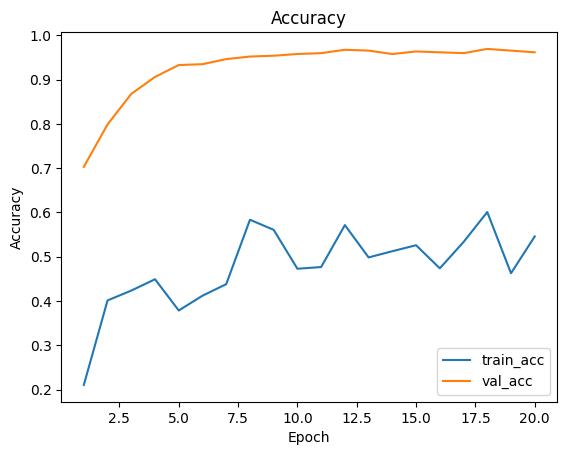

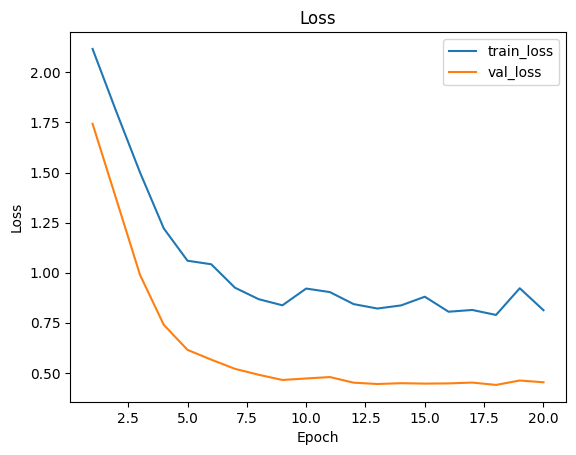

In [7]:
epochs = range(1, len(history["train_acc"])+1)

plt.figure()
plt.plot(epochs, history["train_acc"], label="train_acc")
plt.plot(epochs, history["val_acc"], label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy"); plt.legend(); plt.show()

plt.figure()
plt.plot(epochs, history["train_loss"], label="train_loss")
plt.plot(epochs, history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss"); plt.legend(); plt.show()


Validation accuracy (best): 0.9693

                                precision    recall  f1-score   support

          Braised Chicken Feet       0.98      1.00      0.99        57
          Braised Pig Trotters       0.92      1.00      0.96        60
                 Egg Drop Soup       1.00      0.98      0.99        57
                Egg Fried Rice       0.95      1.00      0.97        35
Hot and Sour Lotus Root Slices       1.00      0.98      0.99        55
          Scallion Oil Noodles       1.00      1.00      1.00        59
        Spicy Chongqing Hotpot       0.98      0.92      0.95        60
                    Spicy Crab       0.93      0.95      0.94        56
                    Spicy Tofu       0.96      0.93      0.95        56
 Stir-fried Shrimp with Garlic       0.96      0.93      0.94        27

                      accuracy                           0.97       522
                     macro avg       0.97      0.97      0.97       522
                  weighted

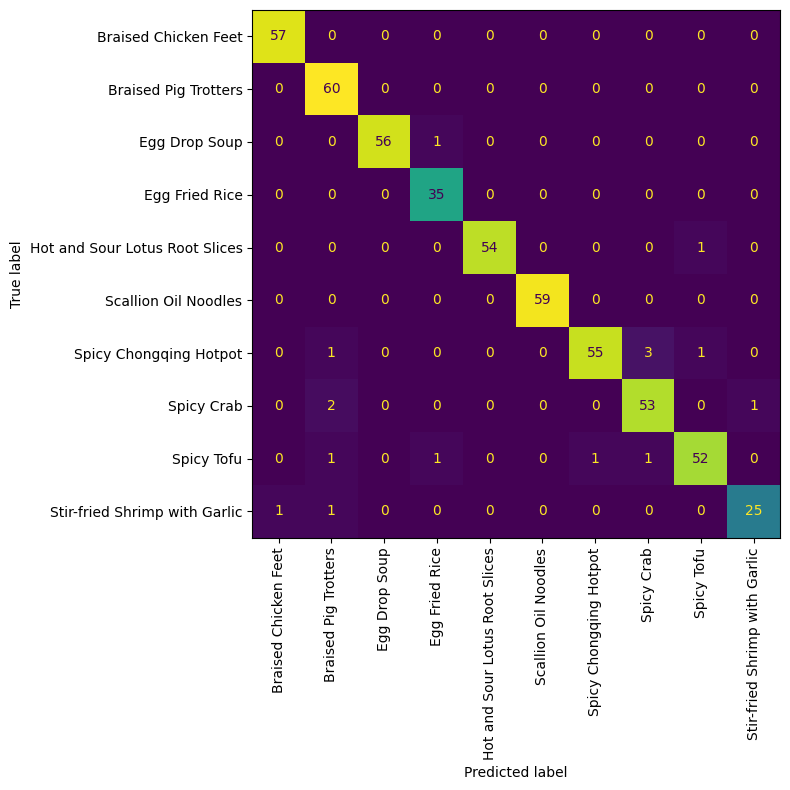

In [8]:
# Reload best checkpoint for evaluation
ckpt = torch.load(best_path, map_location=device)
best_model = build_model(ckpt["model_name"], len(ckpt["classes"])).to(device)
best_model.load_state_dict(ckpt["model"])

val_loss, val_acc, y_true, y_pred = evaluate(best_model, val_ld, criterion, device)
print(f"Validation accuracy (best): {val_acc:.4f}\n")

# Detailed report
target_names = ckpt["classes"]
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(target_names))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, xticks_rotation=90, colorbar=False)
plt.tight_layout()
plt.show()


In [9]:
from PIL import Image

def get_infer_transform(img_size=224):
    mean=[0.485,0.456,0.406]; std=[0.229,0.224,0.225]
    return transforms.Compose([
        transforms.Resize(int(img_size*1.15)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean,std),
    ])

@torch.no_grad()
def predict_image(img_path, ckpt_path=best_path, device=device):
    ckpt = torch.load(ckpt_path, map_location=device)
    model = build_model(ckpt["model_name"], len(ckpt["classes"])).to(device)
    model.load_state_dict(ckpt["model"]); model.eval()
    tfm = get_infer_transform(ckpt["img_size"])
    img = Image.open(img_path).convert("RGB")
    x = tfm(img).unsqueeze(0).to(device)
    logits = model(x)
    probs = torch.softmax(logits, dim=1)[0]
    conf, idx = probs.max(0)
    return ckpt["classes"][idx.item()], float(conf.item())

# Example:
# pred, score = predict_image("path/to/your_image.jpg")
# print(pred, score)


In [10]:
from torchvision import transforms
gray_eval = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

gray_val = datasets.ImageFolder(Path(DATA_DIR)/"val", transform=gray_eval)
gray_ld  = DataLoader(gray_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

val_loss, val_acc, *_ = evaluate(best_model, gray_ld, criterion, device)
print("Grayscale val accuracy:", val_acc)


Grayscale val accuracy: 0.9272030651340997


In [11]:
from sklearn.metrics import classification_report, balanced_accuracy_score
print(classification_report(y_true, y_pred, digits=3))
print("Balanced Acc:", balanced_accuracy_score(y_true, y_pred))


              precision    recall  f1-score   support

           0      0.983     1.000     0.991        57
           1      0.923     1.000     0.960        60
           2      1.000     0.982     0.991        57
           3      0.946     1.000     0.972        35
           4      1.000     0.982     0.991        55
           5      1.000     1.000     1.000        59
           6      0.982     0.917     0.948        60
           7      0.930     0.946     0.938        56
           8      0.963     0.929     0.945        56
           9      0.962     0.926     0.943        27

    accuracy                          0.969       522
   macro avg      0.969     0.968     0.968       522
weighted avg      0.970     0.969     0.969       522

Balanced Acc: 0.9681866914761651
